In [1]:
import os
import json

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset
from tqdm import tqdm
import spacy

import transformer_lens
from probe_model import LinearProbe, Trainer, TrainerConfig

## Setup

In [3]:
device_name = "cpu"
if torch.cuda.is_available():
    device_name = "cuda" # CUDA for NVIDIA GPU

device = torch.device(device_name)
print(f"Device: {device_name}")

Device: cuda:1


In [4]:
model_name = "gpt2-small"
model = transformer_lens.HookedTransformer.from_pretrained(model_name)

Loaded pretrained model gpt2-small into HookedTransformer


In [5]:
# Load the spaCy model
spacy_model = spacy.load("en_core_web_sm")

## Generate dataset

### Load text

In [6]:
with open('datasets/prewar.txt', 'r') as f:
    raw_sentences = [line.rstrip("\n") for line in f.readlines()]

DATASET_CUTOFF = 10000
raw_sentences = raw_sentences[:DATASET_CUTOFF]
np.random.choice(raw_sentences, 5)

array(['the chief justice , in the exercise of his circuit duties , has recently held a circuit court in the state of north carolina .',
       'holding the opinion , as i do , that neither the interests of the government nor of the people of the united states would be promoted by disparaging silver as one of the two precious metals which furnish the coinage of the world , and that legislation which looks to maintaining the volume of intrinsic money to as full a measure of both metals as their relative commercial values will permit would be neither unjust nor inexpedient , i must ask your indulgence to a brief and definite statement of certain essential features in any such legislative measure which i feel it my duty to recommend .',
       'we have treated them as independent nations , without their having any substantial pretensions to that rank .',
       'again disappointment awaited the anxious hope for relief .',
       'let one or two in addition suffice .'], dtype='<U4674')

### Generating text sequences with labels (word index)

In [7]:
def map_word_index(text, prepend_bos=False):
    gpt_tokens = model.to_tokens(text, prepend_bos=prepend_bos).squeeze(0)
    gpt_tokens_str = [model.to_single_str_token(int(t)) for t in gpt_tokens]

    doc = spacy_model(str(text))
    word_idxs = [t.text for t in doc if t.is_alpha]

    if not len(word_idxs):
        return torch.Tensor(), []

    i = 0
    cur = 0 # current word index
    sub_idx = 0 # sub index of current word

    result = []
    while i < len(gpt_tokens_str):
        t = gpt_tokens_str[i].strip()
        # skip if token is just a newline or other whitespace
        if not len(t):
            result.append((t, i, -1))
            i += 1
            continue

        cur_word = word_idxs[cur]
        # if token is part of current word, update sub_idx, continue to next token
        if cur_word.find(t, sub_idx) != -1:
            result.append((t, i, cur))
            sub_idx += len(t)
            i += 1
        else:
            # if token not in cur_word, check next word
            if cur+1 < len(word_idxs) and t in word_idxs[cur+1]:
                cur += 1
                sub_idx = 0
            # if not in cur_word or next word, give up and continue
            else:
                result.append((t, i, -1))
                i += 1 

    return gpt_tokens, result

In [7]:
# check that map_word_index function is working correctly
# for s in tqdm(raw_sentences):
#     tokens, info = map_word_index(s)
#     assert len(tokens) == len(info)

In [8]:
SEQ_LEN = 500

def generate_seq():
    tokens = model.to_tokens("\n", prepend_bos=True).squeeze(0)
    info = [("\n", 0, -1)]

    while len(tokens) < SEQ_LEN:
        next_t, next_info = map_word_index(np.random.choice(raw_sentences))
        if len(next_t):
            tokens = torch.cat((tokens, next_t))
            info.extend(next_info)

    word_idx = np.array(list(map(lambda x: x[2], info)))
    return tokens, word_idx

tokens, word_idx = generate_seq()
np.unique(word_idx, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]),
 array([81, 15, 16, 16, 15, 15, 15, 15, 15, 14, 13, 13, 13, 13, 13, 12, 11,
        11, 11,  9,  9, 10,  9,  8,  8,  8,  9,  8,  8,  8,  8,  8,  8,  8,
         8,  6,  4,  4,  4,  4,  4,  4,  4,  4,  3,  3,  2,  2,  2]))

### Generate Embeddings

In [19]:
N_SEQS = 1000
# cutoff initial tokens because model behavior is weird there
PREFIX_CUTOFF = 50

torch.set_grad_enabled(False)

all_resids = []
all_word_idx = []

for i_batch in tqdm(range(N_SEQS)):
    tokens, word_idx = generate_seq()
    # make sure tokens doesn't exceed GPT2's context length
    tokens = tokens[:1000]

    _, cache = model.run_with_cache(tokens, names_filter=lambda x: x.endswith("resid_post"))
    residuals = cache.stack_activation("resid_post")

    # residuals.shape = (layer, batch, seq_len, model_residual_dimension)
    residuals = residuals[:, 0, PREFIX_CUTOFF+1:, :]
    word_idx = word_idx[PREFIX_CUTOFF:]

    assert residuals.shape[1] == word_idx.shape[0]

    # this mask excludes puncuation and word fragments
    mask = word_idx != -1

    all_resids.append(residuals.cpu().numpy()[:, mask])
    all_word_idx.append(word_idx[mask])



100%|██████████| 1000/1000 [07:41<00:00,  2.17it/s]


In [22]:
x_all_layers = np.concatenate(all_resids, axis=1)
y_all = np.concatenate(all_word_idx)

print(x_all_layers.shape)
print(y_all.shape)

(12, 425028, 768)
(425028,)


In [49]:
N_BUCKETS = 20
percentile_buckets = [(100 // N_BUCKETS) * i for i in range(1, N_BUCKETS)]
cutoffs = np.percentile(y_all, percentile_buckets)
q_binned = np.searchsorted(cutoffs, y_all, side='right')

print(cutoffs)

[ 1.  3.  4.  6.  8. 10. 12. 14. 16. 18. 20. 23. 26. 29. 33. 37. 43. 51.
 64.]


### filter data

In [50]:
LAYER = 2

X = x_all_layers[LAYER, :]
Y = q_binned

print(X.shape)
print(Y.shape)

(425028, 768)
(425028,)


## Training Probes

In [51]:
class ProbingDataset(Dataset):
    def __init__(self, act, y):
        assert len(act) == len(y)
        print(f"dataset: {len(act)} pairs loaded...")
        self.act = act
        self.y = y
        print("y:", np.unique(y, return_counts=True))
        
    def __len__(self, ):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.tensor(self.act[idx]), torch.tensor(self.y[idx]).long()

In [52]:
probing_dataset = ProbingDataset(X, Y)
train_size = int(0.8 * len(probing_dataset))
test_size = len(probing_dataset) - train_size
probe_train_dataset, probe_test_dataset = torch.utils.data.random_split(probing_dataset, [train_size, test_size])
print(f"split into [test/train], [{test_size}/{train_size}]")

dataset: 425028 pairs loaded...
y: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19]), array([13348, 25361, 12594, 24847, 24393, 23779, 22814, 21836, 20753,
       19512, 18519, 25400, 22510, 19867, 22564, 18804, 22946, 22412,
       20528, 22241]))
split into [test/train], [85006/340022]


In [53]:
probe = LinearProbe(device, 768, len(np.unique(Y)))

EXPERIMENT_NAME = f"prewar_{N_BUCKETS}qbin_425k"
folder = f"ckpts/{model_name}/{EXPERIMENT_NAME}/layer{LAYER}"
if os.path.isdir(folder):
    print(f"Warning, {folder} already exists")
config = TrainerConfig(num_epochs=20, ckpt_path=folder)
trainer = Trainer(device, probe, probe_train_dataset, probe_test_dataset, config)

In [54]:
trainer.train()

Epoch 20; Train Loss: 1.97086; Train Acc: 30.708%; Test Acc: 30.225%: 100%|██████████| 20/20 [02:04<00:00,  6.24s/it]


In [55]:
print(trainer.generate_report())

              precision    recall  f1-score   support

           0     0.9737    0.9870    0.9803      2623
           1     0.8429    0.8916    0.8666      5129
           2     0.4816    0.5717    0.5228      2517
           3     0.5510    0.4730    0.5090      5013
           4     0.3953    0.3644    0.3792      4909
           5     0.2871    0.4184    0.3405      4763
           6     0.2585    0.1528    0.1921      4640
           7     0.2025    0.2140    0.2081      4341
           8     0.1707    0.2877    0.2143      4146
           9     0.1652    0.1424    0.1529      3870
          10     0.1558    0.0695    0.0961      3728
          11     0.1829    0.1656    0.1738      5036
          12     0.1577    0.1372    0.1468      4583
          13     0.1310    0.1167    0.1234      4002
          14     0.1683    0.0982    0.1240      4511
          15     0.1276    0.0345    0.0544      3793
          16     0.1503    0.3260    0.2057      4577
          17     0.1730    

### plotting loss curves

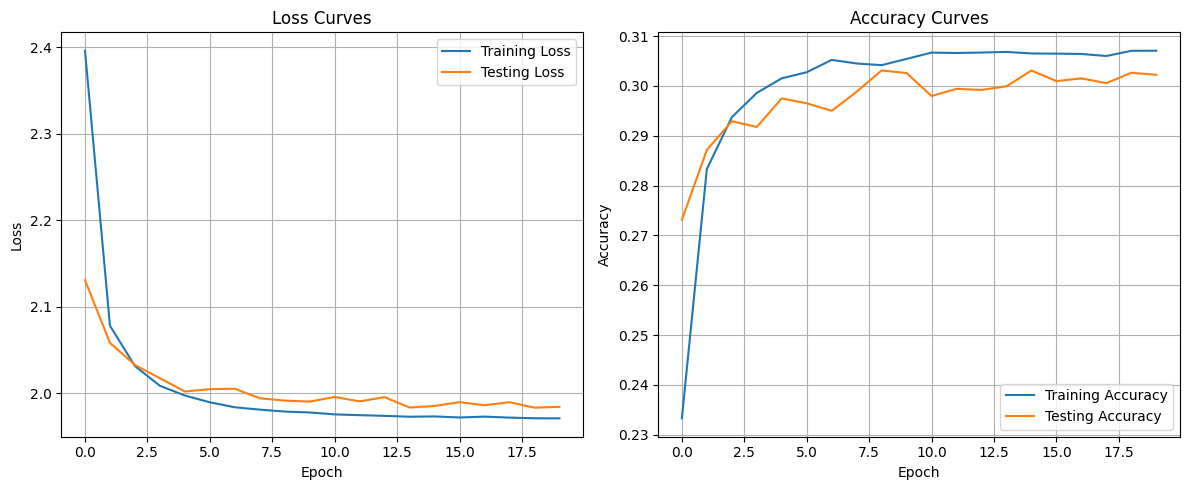

In [56]:
metrics_path = os.path.join(folder, 'metrics.json')

# Load the metrics from the JSON file
with open(metrics_path, 'r') as f:
    metrics = json.load(f)['metrics']

# Extract the loss and accuracy data
train_loss = metrics['train_loss']
test_loss = metrics['test_loss']
train_acc = metrics['train_acc']
test_acc = metrics['test_acc']

# Plot the loss curves
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(test_acc, label='Testing Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### training on all layers

In [ ]:
for LAYER in range(x_all_layers.shape[0]):
    print(f"LAYER: {LAYER}")
    X = x_all_layers[LAYER, :]

    probing_dataset = ProbingDataset(X, Y)
    train_size = int(0.8 * len(probing_dataset))
    test_size = len(probing_dataset) - train_size
    probe_train_dataset, probe_test_dataset = torch.utils.data.random_split(probing_dataset, [train_size, test_size])

    probe = LinearProbe(device, 768, len(np.unique(Y)))

    EXPERIMENT_NAME = f"prewar_{N_BUCKETS}qbin_425k"
    folder = f"ckpts/{model_name}/{EXPERIMENT_NAME}/layer{LAYER}"
    if os.path.isdir(folder):
        print(f"Warning, {folder} already exists")
    config = TrainerConfig(num_epochs=20, ckpt_path=folder)
    trainer = Trainer(device, probe, probe_train_dataset, probe_test_dataset, config)

    trainer.train()